<a href="https://colab.research.google.com/github/ji-hun-choi/SOTA-Study/blob/main/YOLO_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 
import pandas as pd 

import os


In [3]:
import torch
import torch.nn as nn

## 아키텍쳐 구현

In [4]:
architecture_config = [
    (7, 64, 2, 3), # (kernel, output, stride, padding)
    "M",           # MaxPool
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu =nn.LeakyReLU(0.1)
        
    def forward(self, x):
        
        return self.relu(self.bn(self.conv(x)))  

## 모델 구현

In [5]:
class Yolo(nn.Module):
    
    def __init__(self, in_channels = 3, **kwargs):
        
        super(Yolo, self).__init__()
        self.in_channels = 3
        self.architecture = architecture_config
        self.body = self._create_yolo_body(self.architecture)
        self.fcs = self._create_fcs(**kwargs)
        
    
    def forward(self, x):
        
        return self.fcs(torch.flatten(self.body(x), start_dim = 1))
    
    def _create_yolo_body(self,arch):
        
        layers = []
        
        for i in arch:
            
            if type(i) == tuple:
                
                layers += [
                    ConvBlock(in_channels = self.in_channels, out_channels = i[1], kernel_size = i[0], stride = i[2], padding = i[3])
                ]
                self.in_channels = i[1]
            
            elif type(i) == str:
                
                layers += [
                    nn.MaxPool2d(stride = 2, kernel_size = 2)
                ]
                #self.in_channels = self.in_channels//2
                
            elif type(i) == list:
                
                for j in range(i[-1]):
                    
                    layers += [
                        ConvBlock(in_channels = self.in_channels, out_channels = i[0][1], kernel_size = i[0][0], stride = i[0][2], padding = i[0][3])
                    ]
                    self.in_channels = i[0][1]
                    
                    layers += [
                        ConvBlock(in_channels = self.in_channels, out_channels = i[1][1], kernel_size = i[1][0], stride = i[1][2], padding = i[1][3])
                    ]
                    self.in_channels = i[1][1]
                    
        return nn.Sequential(*layers)
        
        
    def _create_fcs(self, split_size, num_boxes, num_cls):
            
        S, B, C = split_size, num_boxes, num_cls
            
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*S*S, 496),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.0),
            nn.Linear(496, S * S * (C + B * 5))
        )

In [6]:
model = Yolo(split_size = 7, num_boxes = 2, num_cls = 20)
print(model)

Yolo(
  (body): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ConvBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1)
    )
    (5): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padd

## IOU

In [8]:
def iOU(pred, target, format = "midpoint"):
    
    if format == "midpoint":
        
        box1_x1 = pred[...,0:1] - pred[...,2:3]/2
        box1_x2 = pred[...,0:1] + pred[...,2:3]/2
        box1_y1 = pred[...,1:2] - pred[...,3:4]/2
        box1_y2 = pred[...,1:2] + pred[...,3:4]/2
        
        box2_x1 = target[...,0:1] - target[...,2:3]/2
        box2_x2 = target[...,0:1] + target[...,2:3]/2
        box2_y1 = target[...,1:2] - target[...,3:4]/2
        box2_y2 = target[...,1:2] + target[...,3:4]/2
        
        
    x1 = torch.max(box1_x1, box2_x1)[0]
    y1 = torch.max(box1_y1, box2_y1)[0]
    x2 = torch.min(box1_x2, box2_x2)[0]
    y2 = torch.min(box1_y2, box2_y2)[0]
    
    inter = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1 = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2 = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    
    union = box1 + box2 - inter + 1e-6
    
    iou = inter/union
    
    return iou

## YOLO loss

In [7]:
class YoloLoss(nn.Module):
    
    def __init__(self, split = 7, Bbox= 2, num_cls =20):
        
        super(YoloLoss, self).__init__()
        self.S = split
        self.B = Bbox
        self.C = num_cls
        self.mse = nn.MSELoss(reduction = "sum")
        self.lambda_noobj = 0.5
        self.lambda_coord = 5
        
    def forward(self, pred, target):
        
        pred = pred.reshape(-1, self.S, self.S, self.C + self.B*5)
        
        iou1 = iOU(pred[...,21:25], target[...,21:25])
        iou2 = iOU(pred[...,26:30], target[...,21:25])
        
        ious = torch.cat([iou1.unsqueeze(0), iou2.unsqueeze(0)], dim = 0)#[[iou1],[iou2]]
        
        #bbox
        iou_max_val, best_bbox = torch.max(ious, dim = 0)
        
        #I_obj_ij
        actual_box = target[...,20].unsqueeze(3)#(-1,S,S,C+B*5) ==> (-1, S,S,1,C+B*5)
        
        
        #box coords
        box_pred = actual_box * (
            (
                best_bbox * pred[...,26:30]
                + (1 - best_bbox) *pred[...,21:25]
            )
        )
        
        box_pred[...,2:4] = torch.sign(box_pred[..., 2:4]) * (torch.sqrt(torch.abs(box_pred[...,2:4] + 1e-6)))
        
        box_target = actual_box * target[...,21:25]
        
        box_target[...,2:4] = torch.sqrt(box_target[..., 2:4])
        
        box_coord_loss = self.mse(
            
            torch.flatten(box_pred, end_dim=-2),
            torch.flatten(box_target, end_dim=-2)

        )
        
        #object loss
        pred_box = (best_bbox * pred[..., 25:26] + (1 - best_bbox) * pred[...,20:21])
        
        obj_loss = self.mse(
            torch.flatten(actual_box * pred_box),
            torch.flatten(actual_box * target[..., 20:21])
        )
        
        
        #no object loss
        no_obj_loss = self.mse(
            torch.flatten((1 - actual_box) * pred[..., 20:21],start_dim = 1),
            torch.flatten((1 - actual_box) * target[..., 20:21],start_dim = 1)
        )
        
        no_obj_loss += self.mse(
            torch.flatten((1 - actual_box) * pred[..., 25:26],start_dim = 1),
            torch.flatten((1 - actual_box) * target[..., 20:21],start_dim = 1)
        )
        
        #class loss
        class_loss = self.mse(
            torch.flatten((actual_box) * pred[..., :20],end_dim = -2),
            torch.flatten((actual_box) * target[..., :20],end_dim = -2)
        )
        
        loss = (
            
            self.lambda_coord * box_coord_loss+
            obj_loss+
            self.lambda_noobj * no_obj_loss+
            class_loss
        
        )
        
        return loss

## NMS

In [9]:
def nMS(boxes, iou_threshold = 0.5, threshold = 0.4,format = "midpoint"):
    #print(boxes[0])
    boxes = [box for box in boxes if box[1]>threshold]
    boxes = sorted(boxes, key = lambda x : x[1], reverse = True)
    box_after_nms = []
    
    while boxes:
        
        max_box = boxes.pop(0)
        boxes = [box for box in boxes if box[0] != max_box[0] or iOU(torch.tensor(box[2:]), torch.tensor(max_box[2:]))>iou_threshold]
        box_after_nms.append(max_box)
        
    return box_after_nms

In [10]:
def convert_cellboxes(predictions, S=7):

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)
        
    return all_bboxes

In [11]:
class PascalDataset(torch.utils.data.Dataset):
    
    def __init__(self, img_path, label_path, csv, S=7, B=2, C=20, transformation = None):
        
        super(PascalDataset, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.annotations = pd.read_csv(csv)
        self.transform = transformation
        self.img_path = img_path
        self.label_path = label_path
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        
        self.label = os.path.join(self.label_path, self.annotations.iloc[index, 1])
        self.img = os.path.join(self.img_path, self.annotations.iloc[index,0])
        boxes = []
        with open(self.label, 'r') as f:
            for label in f.readlines():
                cls, x, y, width, height = [
                    
                    float(x) for x in label.replace("\n", "").split()
                ]
                 .append([cls, x, y, width, height])
        
        img = Image.open(self.img)
        boxes = torch.tensor(boxes)
        
        if self.transform:
            
            img = self.transform(img)
            
        label_tens = torch.zeros((self.S, self.S, self.C + 5 *self.B))
            
        for box in boxes:
            
            cls, x, y, width, height = box.tolist()
            
            i, j = int(self.S*y) , int(self.S*x)
            
            x_cell, y_cell = self.S*x - j, self.S*y - i
            
            width_cell, height_cell = self.S*width, self.S*height
            
            if label_tens[i,j,20] == 0:
                
                label_tens[i,j,20] = 1
                
                box_coord = torch.tensor([
                    x_cell, y_cell, width_cell, height_cell
                ])
                
                label_tens[i,j,21:25] = box_coord
                
                label_tens[i,j,int(cls)] = 1
                
        return img, label_tens

In [12]:
from PIL import Image, ImageDraw
import torchvision.transforms as transform
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

mytrans = transform.Compose([
    
    transform.Resize((448,448)),
    transform.ToTensor(),
])

In [13]:
import gdown
## google drive에서 압축된 dataset download
url = 'https://drive.google.com/uc?id=1Tl1ootGX2xq4zd3unCLmql93AJBLBiPk'
url1 = 'https://drive.google.com/uc?id=1bfo0zmgHuPuDJGJm-OHeajoOLq7xVwAf'
url2 = 'https://drive.google.com/uc?id=1IQ51xlwbZdSbUJYYzoRZyBT_d6MMHoJS'
fname = 'voc-20220904T175524Z-001.zip'
fname1 = 'voc-20220904T175524Z-002.zip'
fname2 = 'voc-20220904T175524Z-003.zip'

gdown.download(url, fname, quiet=False)
gdown.download(url1, fname1, quiet=False)
gdown.download(url2, fname2, quiet=False)
!unzip voc-20220904T175524Z-001.zip # test를 위한 data.zip 파일 가져오기.
!unzip voc-20220904T175524Z-002.zip
!unzip voc-20220904T175524Z-003.zip

Downloading...
From: https://drive.google.com/uc?id=1Tl1ootGX2xq4zd3unCLmql93AJBLBiPk
To: /content/voc-20220904T175524Z-001.zip
100%|██████████| 2.15G/2.15G [00:07<00:00, 277MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bfo0zmgHuPuDJGJm-OHeajoOLq7xVwAf
To: /content/voc-20220904T175524Z-002.zip
100%|██████████| 2.15G/2.15G [00:08<00:00, 239MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IQ51xlwbZdSbUJYYzoRZyBT_d6MMHoJS
To: /content/voc-20220904T175524Z-003.zip
100%|██████████| 337M/337M [00:01<00:00, 188MB/s]


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: voc/images/005168.jpg   
  inflating: voc/images/004806.jpg   
  inflating: voc/images/005038.jpg   
  inflating: voc/images/005018.jpg   
  inflating: voc/images/005048.jpg   
  inflating: voc/images/004969.jpg   
  inflating: voc/images/004980.jpg   
  inflating: voc/images/005286.jpg   
  inflating: voc/images/004830.jpg   
  inflating: voc/images/004962.jpg   
  inflating: voc/images/005108.jpg   
  inflating: voc/images/004786.jpg   
  inflating: voc/images/004800.jpg   
  inflating: voc/images/005133.jpg   
  inflating: voc/images/004903.jpg   
  inflating: voc/images/005231.jpg   
  inflating: voc/images/004873.jpg   
  inflating: voc/images/004817.jpg   
  inflating: voc/images/004981.jpg   
  inflating: voc/images/005235.jpg   
  inflating: voc/images/005209.jpg   
  inflating: voc/images/004912.jpg   
  inflating: voc/images/004957.jpg   
  inflating: voc/images/005151.jpg   
  inflating: voc/images/004879.jpg   
  inflating: v

In [15]:
dataset = PascalDataset('/content/voc/images', '/content/voc/labels', '/content/voc/100examples.csv', transformation = mytrans)

In [16]:
loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = 1,  #batch
        num_workers=2,
        pin_memory=True,
        shuffle=True,
        drop_last=False)

In [17]:
def drawBox(x, y):
    '''
    x, y for one example
    x torch tensor channel first
    
    '''
    
    img = x.permute(1,2,0)
    #plt.imshow(img)
    #print(y.shape)
    img = (img.numpy()*255).astype(np.uint8)
    #print(img)
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    boxes = cellboxes_to_boxes(y)
    boxes = nMS(boxes)
    #print(boxes)
    for box in boxes:
        
        x1, y1, x2, y2 = box_to_corners(box)
        #print([(x1, y1), (x2, y2)])
        #print(img.numpy())
        draw.rectangle([(x1, y1), (x2, y2)], outline ="red", width = 5)
    plt.imshow(img)

In [18]:
def box_to_corners(boxes):
    #print(boxes)
    box_minx = boxes[2] - (boxes[4]/2)
    box_maxx = boxes[2] + (boxes[4]/2)
    
    box_miny = boxes[3] - (boxes[5]/2)
    box_maxy = boxes[3] + (boxes[5]/2)

    return [box_minx*448, box_miny*448, box_maxx*448, box_maxy*448]

In [19]:
seed = 123
torch.manual_seed(seed)

#model = Yolo()
num_epochs = 10
batch = 16

w8_decay = 0
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5)

In [20]:
#pred = torch.rand((1,7,7,30))
#tar = torch.rand((1,7,7,25))
lossfn = YoloLoss()
#loss.forward(pred, tar)

In [21]:
def train():
    
    for epoch in range(num_epochs):
        
        loop = tqdm(loader, leave = True)
        
        mean_loss = []
        
        num_crct = 0
        num_sample = 0
        
        for b_id, (x, y) in enumerate(loop):

            pred = model(x)
            #print("claculated out...")
            loss = lossfn(pred, y)
            l = loss.item()
            #print("calculated loss...")
            optimizer.zero_grad()
            loss.backward()
            #print("calculated gradient...")
            optimizer.step()

            '''
            num_crct = (pred.max(1)[1] == y).sum()
            num_sample = x.shape[0]
            '''
            #acc = num_crct/num_sample
            
            mean_loss.append(l)
            loop.set_postfix(loss=l)#, acc=acc)

        print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [22]:
train()

100%|██████████| 103/103 [02:29<00:00,  1.45s/it, loss=26.7]


Mean loss was 41.642705982171215


100%|██████████| 103/103 [02:28<00:00,  1.44s/it, loss=83.1]


Mean loss was 21.161200046539307


100%|██████████| 103/103 [02:27<00:00,  1.43s/it, loss=34.2]


Mean loss was 19.371471025411363


100%|██████████| 103/103 [02:32<00:00,  1.48s/it, loss=89.7]


Mean loss was 19.000918386051957


100%|██████████| 103/103 [02:29<00:00,  1.45s/it, loss=15.7]


Mean loss was 16.251616378432338


100%|██████████| 103/103 [02:32<00:00,  1.48s/it, loss=3.11]


Mean loss was 14.434232917804163


100%|██████████| 103/103 [02:28<00:00,  1.44s/it, loss=6.34]


Mean loss was 12.973571428974855


100%|██████████| 103/103 [02:30<00:00,  1.47s/it, loss=4.63]


Mean loss was 12.671868275670173


100%|██████████| 103/103 [02:28<00:00,  1.44s/it, loss=6.51]


Mean loss was 11.725259484596624


100%|██████████| 103/103 [02:30<00:00,  1.46s/it, loss=1.94]

Mean loss was 10.74099799498771


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


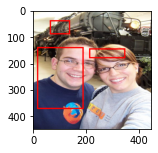

In [23]:
w = 10
h = 10
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 4

for x, y in loader:
    
    pred = model(x)
    
    for i in range(x.shape[0]):
    
        img = x[i].permute(1,2,0)
        #plt.imshow(img)
        #print(y.shape)
        img = (img.numpy()*255).astype(np.uint8)
        #print(img)
        img = Image.fromarray(img)
        draw = ImageDraw.Draw(img)
        boxes = cellboxes_to_boxes(pred)[i]
        boxes = nMS(boxes)
        #print(boxes)
        for box in boxes:

            x1, y1, x2, y2 = box_to_corners(box)
            #print([(x1, y1), (x2, y2)])
            #print(img.numpy())
            draw.rectangle([(x1, y1), (x2, y2)], outline ="red", width = 5)
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
plt.show()

In [ ]:
class YoloLossAP(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLossAP, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = iOU(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = iOU(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss